In [1]:
#!pip install arch  # uncomment to install the arch package

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import scipy
from arch.univariate import arch_model

In [2]:
DATA_PATH = os.path.join("..", "..", "..", "data")  # document-wide constants are uppercase by convention

# 1
## a: Time series plot,  histogram, correlogram of squared returns

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "sp500.csv"), index_col = "Date")
df.index = pd.DatetimeIndex(df.index, dayfirst=True).to_period('D')
df["log_return"] = 100 * (np.log(df["Adj Close"]) - np.log(df["Adj Close"]).shift(1))
df.dropna(inplace=True)
df.tail()

,Adj Close,log_return
Date,,
2022-10-21,3752.750000,2.344776
2022-10-24,3797.340088,1.181194
2022-10-25,3859.110107,1.613577
2022-10-26,3830.600098,-0.741514
2022-10-27,3807.300049,-0.610119


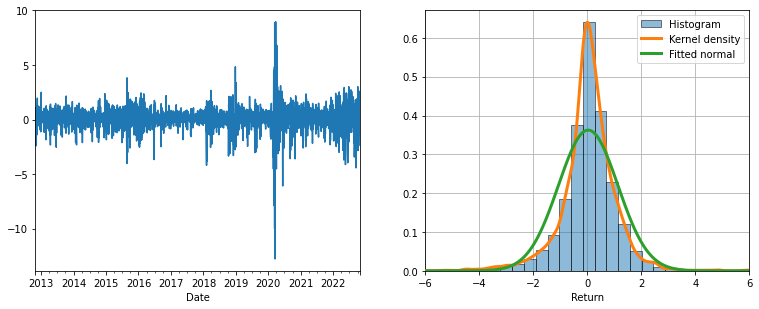

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
df["log_return"].plot(ax=ax1);
ax2.hist(df["log_return"], bins=50, density=True, label="Histogram", zorder=5, edgecolor="k", alpha=0.5)
kde = sm.nonparametric.KDEUnivariate(df["log_return"]).fit()
ax2.plot(kde.support, kde.density, lw=3, label="Kernel density", zorder=10)
norm_pdf = scipy.stats.norm.pdf(x=kde.support, loc=df["log_return"].mean(), scale=df["log_return"].std())
ax2.plot(kde.support, norm_pdf, lw=3, label="Fitted normal", zorder=15)
ax2.set_xlabel("Return")
ax2.set_xlim(-6, 6)
ax2.legend(loc="best")
ax2.grid(True, zorder=-5)
#fig.savefig("stylized_facts.pdf")

The time series plot shows volatility clustering. The histogram, which we have overlaid with a kernel density estimate and a fitted normal density, shows that the data have fat tails and some skewness. Both are very typical findings for equity returns, especially at daily or higher frequency.

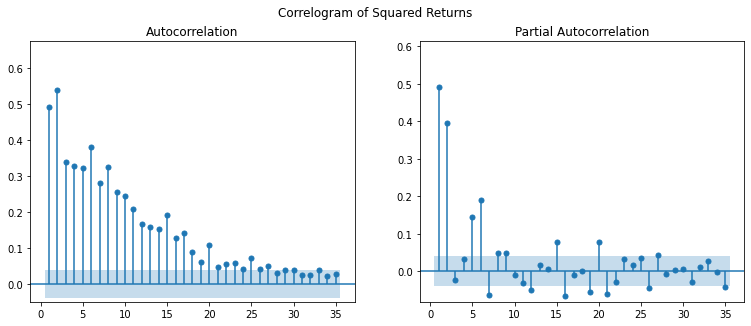

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Squared Returns')
sm.graphics.tsa.plot_acf(np.power(df["log_return"], 2), ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(np.power(df["log_return"], 2), ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");
#fig.savefig("sp500corr_sq.pdf")

In [6]:
sm.stats.diagnostic.acorr_ljungbox(np.power(df["log_return"], 2), 5)

,lb_stat,lb_pvalue
1,608.233164,2.710445e-134
2,1344.067822,1.378418e-292
3,1633.504438,0.000000e+00
4,1907.204982,0.000000e+00
5,2169.132380,0.000000e+00


There is clear evidence of autocorrelation in the squared returns; most autocorrelations are individually significant in the plot, and the $Q$-test confirms joint significance. This indicates the presence of volatility clustering. Since the SPACF seems to more or less drop to zero after 6 lags, we might try an ARCH(6) model. Usually, a simple GARCH(1, 1) will do better though.

## b: ARCH-LM test
The test is designed to work with regression residuals, not raw returns. So we begin by regressing the returns on an intercept and then use the residuals from this regression (this is equivalent to de-meaning the returns).

In [7]:
model = smf.ols(formula = "log_return ~ 1", data = df).fit()

Applying the LM test to the residuals yields

In [8]:
LM, pLM, F, pF, res = sm.stats.diagnostic.het_arch(model.resid, nlags=5, store=True)
print("LM = ", LM, "\np  = ", pLM)

LM =  936.7230264452857 
p  =  2.9978163480469816e-200


There are two versions of the test, the LM Test and an $F$-test. The `het_arch` returns the LM statistic, its $p$-value, the $F$ statistic, its $p$-value, and the results of the auxiliary regression if `store=True` is specified, in that order. We focus on the LM statistic, which is just $T\cdot R^2$ in the auxiliary regression
$$\hat{u}_{t}^{2}=\gamma _{0}+\gamma _{1}\hat{u}_{t-2}^{2}+\gamma _{2}\hat{u}_{t-2}^{2} + \gamma _{3}\hat{u}_{t-3}^{2}+\gamma _{4}\hat{u}_{t-4}^{2}+\gamma _{1}\hat{u}_{t-5}^{2}+e_{t}.$$

Here, $T\cdot R^2=936.7$, which is much larger than the critical value from the $\chi^2(5)$ distribution, which is

In [9]:
scipy.stats.chi2.ppf(.95, 5)


11.070497693516351

We thus strongly reject the null of no volatility clustering. The same conclusion can, of cource, be drawn from the $p$-value $2.99\cdot 10^{-200}$, which is essentially zero.

We can look at the results of the auxiliary regression as follows.

In [10]:
print(res.resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     298.0
Date:                Mon, 16 Oct 2023   Prob (F-statistic):          8.83e-251
Time:                        17:07:14   Log-Likelihood:                -7173.1
No. Observations:                2512   AIC:                         1.436e+04
Df Residuals:                    2506   BIC:                         1.439e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3179      0.088      3.618      0.0

Here, the dependent variable `y` refers to $\hat{u}^2_t$, the regressor `x1` refers to $\hat{u}^2_{t-1}$, etc. We can now compute the test statistic as
$$T\cdot R^2:$$

In [11]:
0.373 * 2512

936.976

This matches the result above up to rounding error. The test statistic can then be compared with the critical value 11.07 as before. **Note**: In an exam, instead of  providing the output of `sm.stats.diagnostic.het_arch`, I might just give you the output of `res.resols.summary()` above, and ask you to do the test by hand.

# 1
# c: Historical volatility
The historical volatility forecasts as defined in the slides can be obtained via

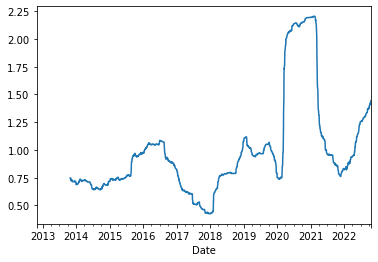

In [12]:
np.sqrt(np.power(df["log_return"], 2).rolling(250, closed="left").mean()).plot();

This averages the squared returns within the window, excluding the rightmost one (`closed=left`) because that is not available when forecasting. If you don't want to assume a zero mean for the returns, an alternative is to use

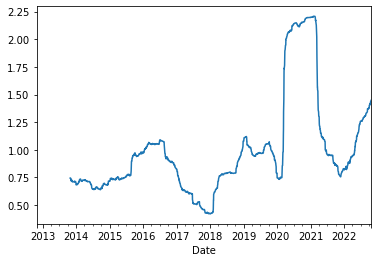

In [13]:
df["log_return"].rolling(250, closed="left").std().plot();

This will subtract the mean return for each window before averaging. As you can see, the results are barely distinguishable, because the mean is close to zero for daily returns.

# 1
# d: EWMA volatility

The RiskMetrics / EWMA volatility as defined in the slides is obtained as follows.

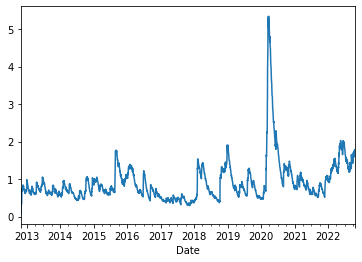

In [14]:
np.sqrt(np.power(df["log_return"], 2).shift(1).ewm(alpha=0.06, adjust=False).mean()).plot();

Note the `shift(1)`, which excludes the last observation, which isn't available for forecasting (unlike `rolling`, `EWMA` doesn't let us specify `closed`). Also note that we have to specify $\alpha=1-\lambda=1-0.94=0.06$ instead of $\lambda$.

If you don't want to assume a zero mean, you can instead do

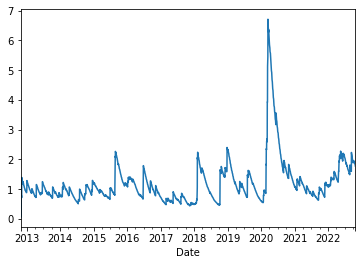

In [15]:
np.sqrt(np.power(df["log_return"], 2).shift(1).ewm(alpha=0.06, adjust=False).std()).plot();

The following commands were used to create the plot in the slides.

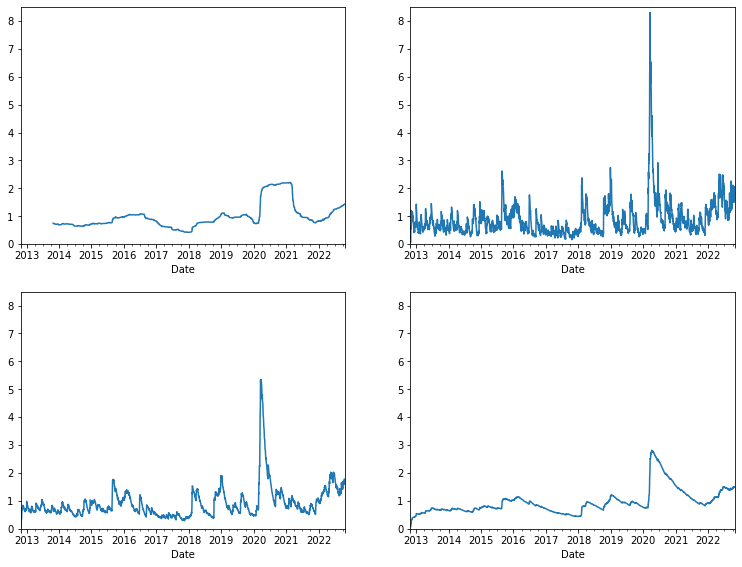

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12.8, 9.6))
np.sqrt(np.power(df["log_return"], 2).rolling(250, closed="left").mean()).plot(ax=ax1[0], ylim=(0, 8.5))
np.sqrt(np.power(df["log_return"], 2).shift(1).ewm(alpha=0.2, adjust=False).mean()).plot(ax=ax1[1], ylim=(0, 8.5))
np.sqrt(np.power(df["log_return"], 2).shift(1).ewm(alpha=0.06, adjust=False).mean()).plot(ax=ax2[0],ylim=(0, 8.5))
np.sqrt(np.power(df["log_return"], 2).shift(1).ewm(alpha=0.01, adjust=False).mean()).plot(ax=ax2[1],ylim=(0, 8.5));
#fig.savefig("volaplots.pdf")

# 1
## e: GARCH modeling
We start with a an ARCH(6) model, since we found that the PACF dropped to zero after 6 lags. Note that the `arch` packages names the lag lengths differently from our convention; where we use $p$, it uses $q$, and vice versa. Hence, we have to pass `p=6`.

In [18]:
model1 = arch_model(df["log_return"], mean='Constant', vol='ARCH', p=6).fit(disp=None)
print(model1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3125.84
Distribution:                  Normal   AIC:                           6267.68
Method:            Maximum Likelihood   BIC:                           6314.33
                                        No. Observations:                 2517
Date:                Mon, Oct 16 2023   Df Residuals:                     2516
Time:                        17:07:49   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0819  1.418e-02      5.777  7.625e-09 [5.414e-0

All ARCH coefficients are significant. To test the model, we obtain the standardized residuals $\hat{z}$ and plot their correlogram, as well as that of the squares:

In [19]:
z = model1.std_resid

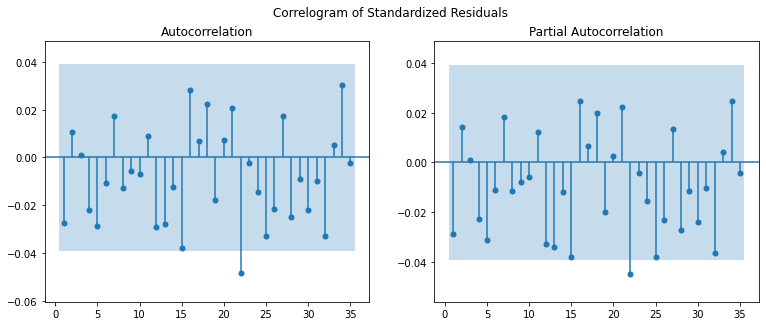

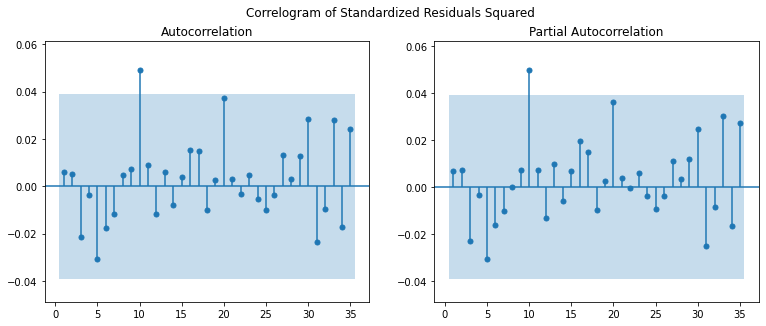

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Standardized Residuals')
sm.graphics.tsa.plot_acf(z, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(z, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Standardized Residuals Squared')
sm.graphics.tsa.plot_acf(np.power(z, 2), ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(np.power(z, 2), ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");

They look mostly fine. We can confirm that we have successfully removed the volatility clustering by applying an ARCH-LM test to the standardized residuals:

In [21]:
sm.stats.diagnostic.het_arch(model1.std_resid, nlags=5)

(3.702649937234442, 0.5929696609380561, 0.7398517358779074, 0.5935510578809104)

The $p$-value is 0.59, so we don't reject the null that there is no remaining volatility clustering. Alternatively, the ARCH-LM test can also be performed using the `arch` package directly, rather than going via `statsmodels`, as follows:

In [23]:
model1.arch_lm_test(standardized=True, lags=5)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 3.7100
P-value: 0.5919
Distributed: chi2(5)
WaldTestStatistic, id: 0x1f4123a6ec8

Apart from minor numerical differences, the result is the same. 

Although the ARCH(6) model performs well, we also try a simple GARCH(1, 1), because I know from experience that this tends to work well.


In [24]:
model2 = arch_model(df["log_return"], mean='Constant', vol='GARCH', p=1, q=1,).fit(disp=None)
print(model2.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3119.24
Distribution:                  Normal   AIC:                           6246.48
Method:            Maximum Likelihood   BIC:                           6269.80
                                        No. Observations:                 2517
Date:                Mon, Oct 16 2023   Df Residuals:                     2516
Time:                        17:08:17   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0803  1.410e-02      5.697  1.219e-08 [5.269e-0

The estimated coefficients are $\hat{\beta}=0.74$ and $\hat\alpha=0.22$ and are significant. The estimates are a bit unusual; typically we find $\hat\beta$ around 0.9 for daily returns (c.f. $\lambda=0.94$ for the RiskMetrics model). The fact that the estimated model is close to the stationarity border (recall that stationarity requires $\alpha+\beta<1$) is typical, though. The correlograms of the standardized residuals and their squares look as follows.

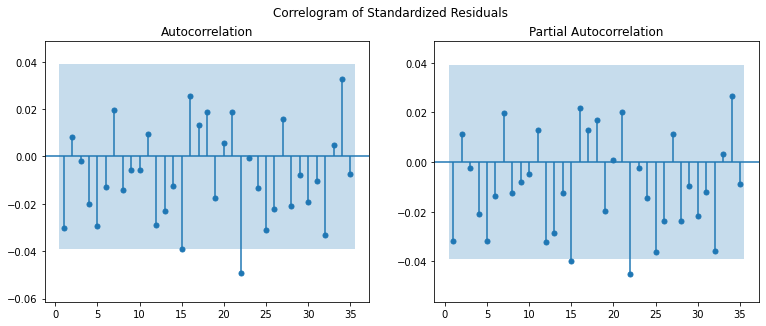

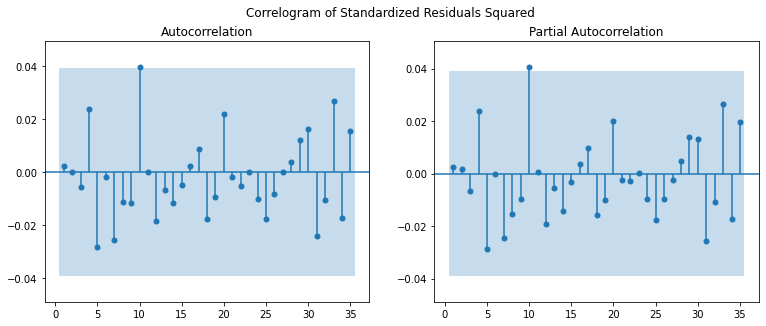

In [25]:
z = model2.std_resid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Standardized Residuals')
sm.graphics.tsa.plot_acf(z, ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(z, ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");
#fig.savefig("corr_resids.pdf")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
fig.suptitle('Correlogram of Standardized Residuals Squared')
sm.graphics.tsa.plot_acf(np.power(z, 2), ax=ax1, bartlett_confint=False, zero=False, auto_ylims=True)
sm.graphics.tsa.plot_pacf(np.power(z, 2), ax=ax2, zero=False, auto_ylims=True, method="ols-inefficient");
#fig.savefig("corr_resids_sq.pdf")

Their appear to be no remaining volatility clustering. This is confirmed by the ARCH-LM test, which does not reject:

In [26]:
model2.arch_lm_test(standardized=True, lags=5)

ARCH-LM Test
H0: Standardized residuals are homoskedastic.
ARCH-LM Test
H1: Standardized residuals are conditionally heteroskedastic.
Statistic: 3.5342
P-value: 0.6182
Distributed: chi2(5)
WaldTestStatistic, id: 0x1f4123076c8

Both the ARCH(6) and the GARCH(1, 1) model seem to work fine. We choose to stick with the latter, since we prefer smaller models. This choice is confirmed by the BIC, which at 6269.80 is lower compared to the 6314.33 for the ARCH(6) model.

We plot the conditional volatility, and a histogram of the standardized residuals.

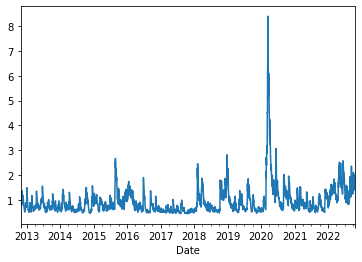

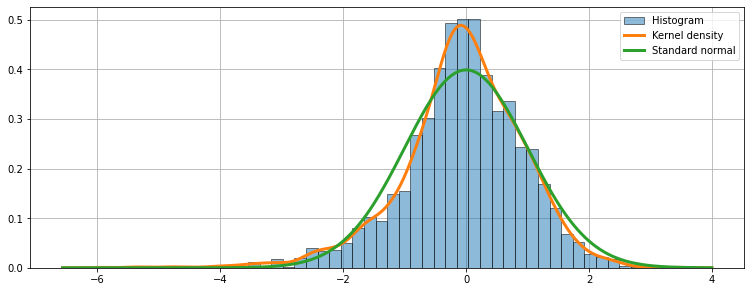

In [27]:
model2.conditional_volatility.plot();
#plt.savefig("sp500sigmas.pdf")
fig, ax = plt.subplots(1, figsize=(12.8, 4.8))
ax.hist(z, bins=50, density=True, label="Histogram", zorder=5, edgecolor="k", alpha=0.5)
kde = sm.nonparametric.KDEUnivariate(z).fit()
ax.plot(kde.support, kde.density, lw=3, label="Kernel density", zorder=10)
norm_pdf = scipy.stats.norm.pdf(x=kde.support)
ax.plot(kde.support, norm_pdf, lw=3, label="Standard normal", zorder=15)
ax.legend(loc="best")
ax.grid(True, zorder=-5)
#fig.savefig("hist_resids.pdf")

The residuals don't seem to follow a normal distribution, another typical finding. This is confirmed by the JB test, which rejects the null of normality:

In [28]:
sm.stats.stattools.jarque_bera(z)

(745.5940336252594,
 1.2482820579770435e-162,
 -0.7401193864171578,
 5.217713294465563)

This means that we  were right to use Bollerslev-Wooldridge standard errors, which are the default in `arch`. Alternatively, we could have specified a different error distribution, but we'll reserve that for next week.



The only thing that is left to consider is asymmetry and the leverage effect. There is no built-in test for this, so we'll just go ahead and estimate a TARCH(1, 1, 1) model. `arch` calls this GARCH, not TARCH or TJR, but we have to specify `o=1`:

In [29]:
model3 = arch_model(df["log_return"], mean='Constant', vol='GARCH', p=1, o=1, q=1,).fit(disp=None)
print(model3.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3088.09
Distribution:                  Normal   AIC:                           6186.18
Method:            Maximum Likelihood   BIC:                           6215.34
                                        No. Observations:                 2517
Date:                Mon, Oct 16 2023   Df Residuals:                     2516
Time:                        17:08:35   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0475  1.357e-02      3.503  4.609e-04 [2.

The asymmetry coefficient $\hat\gamma=0.255$ is clearly significant, so there is clear evidence of leverage. Also note that the ARCH coefficient $\alpha$ has almost become insignificant. This means that volatility reacts much more strongly to bad news (negative returns) than to good news. 

Finally, we plot the volatilites and the NIC:

# 1
## f: Plotting the volatility and the NIC:
Having found our final model, we make a plot of the conditional volatility, and of the news impact curve.

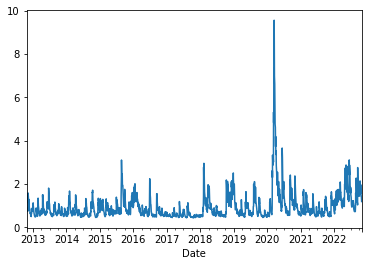

In [30]:
model3.conditional_volatility.plot();

The unconditional, or average, volatility is computed as
$$\sigma^2 = \omega / (1-\alpha-.5\gamma-\beta)=1.28787.$$ 
This will be needed for the news impact curve that we plot below. For comparison, we also plot the NIC of the GARCH model.

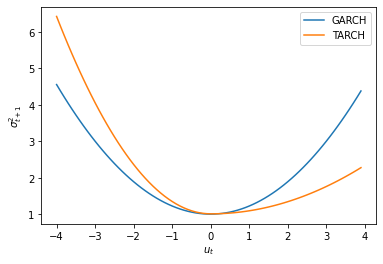

In [31]:
def NIC_TARCH(u, omega, alpha, gamma, beta):
    sig2 = omega / (1 - alpha - 0.5*gamma - beta)    
    return omega + alpha * u**2 + (gamma * u**2 ) * (u<0) + beta * sig2

def NIC_GARCH(u, omega, alpha, beta):    
    return NIC_TARCH(u, omega, alpha, 0, beta)

u = np.arange(-4, 4, .1)
plt.plot(u, NIC_GARCH(u, *model2.params[1:5]), label="GARCH")
plt.plot(u, NIC_TARCH(u, *model3.params[1:5]), label="TARCH")
plt.xlabel(r"$u_t$")
plt.ylabel(r'$\sigma^2_{t+1}$')
plt.legend();
#plt.savefig("NIC.pdf")

# 1
## g: Forecasting
We begin with a manual forecast, as you would be expected to do in an exam. To do that, we need the estimated $\widehat{\sigma}_t$ and $\hat{u}_t$, and the estimated parameters.    

In [32]:
_, omega, alpha, gamma, beta = model3.params
print(omega, alpha, gamma, beta)

0.041939670515507795 0.0831373736918038 0.25472412448254 0.756935428959439


In [33]:
model3.resid[-1]  # note that this is the unstandardized residual u

-0.657664026225543

In [34]:
model3.conditional_volatility[-1]

1.1847834937944055

We find that the residual for Oct 27 is -0.65766, and the corresponding $\widehat{\sigma}_t$ is 1.18478. We then plug into our estimated model as follows.
\begin{align*}
\widehat{\sigma} _{t+1}^{2}&=\hat\omega +\hat\alpha \hat u_{t}^{2}+\hat\gamma \hat u_{t}^{2}\text{I}_{t}+\hat\beta \hat\sigma _{t}^{2}\\
&=0.041939 +0.08313 \hat u_{t}^{2}+0.25472 \hat u_{t}^{2}\cdot 1+0.75693 \hat\sigma _{t}^{2}\\
&=0.041939 +0.08313 \cdot (-0.65766)^{2}+0.25472 \cdot (-0.65766)^{2}\cdot 1+0.75693 \cdot 1.18478^{2}\\
&=1.25059;
\end{align*}
note that the indicator function is 1 because $\hat{u}_t$ is negative.

We can also use Python to do the calculation:

In [35]:
omega + alpha * model3.resid[-1]**2 + gamma * model3.resid[-1]**2 * (model3.resid[-1]<0) + beta * model3.conditional_volatility[-1]**2

1.2505914814892038

Or we can just leave the forecasting to Python altogether:

In [39]:
model3.forecast(reindex=False).variance

,h.1
Date,
2022-10-27,1.250591
